## Preprocessing Section

## Data Loading 

In [1]:
import sys
import os
import importlib

# Add project to path so we can import our modules
sys.path.append(os.path.abspath(".."))

# Import functionality from our source code
import src.data_loading.data_loader as data_loader
importlib.reload(data_loader)
from src.data_loading.data_loader import load_data, get_numerical_features, get_categorical_features


# Load the data
df = load_data()

list_numerical_features = get_numerical_features(df)
list_categorical_features = get_categorical_features(df)

Loading data from c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\raw\credit_score_dataset.csv
Loaded dataset with 100000 rows and 27 columns


## Categorical features

In [2]:
import src.preprocessing.categorical.categorical_features as categorical_features
importlib.reload(categorical_features)
from src.preprocessing.categorical.categorical_features import *

visualize_unique_categories(df, list_categorical_features);


Column 'ID' (90058 uniques):
the length of the list is too long to be printed entirely. Sample:
['0x1603', '0x1604', '0x1605', '0x1607', '0x1608', '0x1609', '0x160e', '0x160f', '0x1610', '0x1611']

Column 'Customer_ID' (12500 uniques):
the length of the list is too long to be printed entirely. Sample:
['CUS_0xd40', 'CUS_0x21b1', 'CUS_0x2dbc', 'CUS_0xb891', 'CUS_0x1cdb', 'CUS_0x95ee', 'CUS_0x284a', 'CUS_0x5407', 'CUS_0x4157', 'CUS_0xba08']

Column 'Month' (8 uniques):
['February', 'April', 'May', 'June', 'July', 'August', 'January', 'March']

Column 'Name' (10139 uniques):
the length of the list is too long to be printed entirely. Sample:
['Aaron Maashoh', 'Rick Rothackerj', 'Langep', 'Jasond', 'Deepaa', 'Np', 'Nadiaq', 'Annk', 'Charlie Zhur', 'Jamesj']

Column 'City' (4 uniques):
['Lonton', 'Standhampton', 'BadShire', 'ZeroVille']

Column 'Street' (31 uniques):
['Oxford Street', 'Old Street', 'Downing Street', 'Jubilee Street', 'Elm Street', 'Market Street', 'King Street', 'Abbey Driv

### Drop Identifiers Columns

In [ ]:
#Save customer id its needed for datasplit
customer_ids=df['Customer_ID'].copy()

IDENTIFIERS_TO_DROP = [
    'ID', 
    'Customer_ID',
    'Name',
    'SSN'
]

# drop the columns that are purely identifiers and that can add bias to the model
df = df.drop(columns=IDENTIFIERS_TO_DROP)

### Handle "Street" feature

In [4]:
df = add_space_before_word(df, feature_column='Street', separator_word='Street')

### Handle "Credit History Age" feature

In [5]:
print("Credit_History_Age information before parsing:")
df["Credit_History_Age"].info()

print("\n"+"-"*100+"\n")

df["Credit_History_Age"] = df["Credit_History_Age"].apply(parse_string_time_period)

print("Credit_History_Age information after parsing:")
df["Credit_History_Age"].info()

Credit_History_Age information before parsing:
<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: Credit_History_Age
Non-Null Count  Dtype 
--------------  ----- 
81791 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB

----------------------------------------------------------------------------------------------------

Credit_History_Age information after parsing:
<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: Credit_History_Age
Non-Null Count  Dtype  
--------------  -----  
81791 non-null  float64
dtypes: float64(1)
memory usage: 781.4 KB


### Handle "Type of Loan" feature - Converting in Multiple Binary Numeric Features

In [6]:
# Handling Type of Loan feature
original_count_unique_categories = df['Type_of_Loan'].nunique()

visualize_top_n_categories(df, column='Type_of_Loan', top_n=25);

df['Type_of_Loan'] = df['Type_of_Loan'].fillna('Missing_Loan')

unique_loan_types_and_counts = get_unique_values_and_counts(df, column='Type_of_Loan')

# Print the discovered loan types and their frequencies
print(f"Discovered {len(unique_loan_types_and_counts)} unique values")
for unique_value, count in list(unique_loan_types_and_counts.items()): 
    print(f"- {unique_value}: {count:,} occurrences")


df = transform_to_binary_features(df, column='Type_of_Loan', unique_values=unique_loan_types_and_counts.keys(), feature_name='Loan')


# add "Loan" suffix to the column "Has_Not_Specified" for better readability
df.rename(columns={'Has_Not_Specified': 'Has_Not_Specified_Loan'}, inplace=True)

# Verify the transformation
print(f"\nOriginal unique values:", {original_count_unique_categories})
print("\nBinary Features (numeric) created from the categories of 'Type of Loan':")
for col in [c for c in df.columns if c.startswith('Has_')]:
    print(f"- {col}: {df[col].sum():,} records - type: {df[col].dtype}")


# Drop the original Type_of_Loan column
df.drop(columns=['Type_of_Loan'], inplace=True)


Top 25 Categories (out of 6261 unique values):
Total records analyzed: 100000

Detailed breakdown:
 1. Missing                                                                20,312 records (20.31%)
 2. Not Specified                                                           1,272 records (1.27%)
 3. Credit-Builder Loan                                                     1,143 records (1.14%)
 4. Debt Consolidation Loan                                                 1,133 records (1.13%)
 5. Personal Loan                                                           1,128 records (1.13%)
 6. Student Loan                                                            1,117 records (1.12%)
 7. Payday Loan                                                             1,061 records (1.06%)
 8. Mortgage Loan                                                           1,058 records (1.06%)
 9. Auto Loan                                                               1,024 records (1.02%)
10. Home Equity L

### Handle object columns with problematic-numeric values and convert to numeric

In [7]:
import src.preprocessing.categorical.problematic_numeric_values as problematic_numeric_values
importlib.reload(problematic_numeric_values)
from src.preprocessing.categorical.problematic_numeric_values import convert_non_numeric_strings_to_nan, identify_problematic_characters,  remove_characters, convert_to_numeric

# Features that should be numerical but are currently 'object'
PROBLEMATIC_NUMERICAL_FEATURES = [
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Outstanding_Debt',
    'Amount_invested_monthly'
]

# Print info of the columns before cleaning and conversion to numeric
print("\nInfo for columns to be converted to numeric:")
print("-" * 50)
df[PROBLEMATIC_NUMERICAL_FEATURES].info()

# Convert strings that don't contain digits to NaN
df = convert_non_numeric_strings_to_nan(df, PROBLEMATIC_NUMERICAL_FEATURES)

# Identify problematic elements in the columns
print("Identifying problematic characters...\n")
problematic_characters = identify_problematic_characters(df, PROBLEMATIC_NUMERICAL_FEATURES)
print(f"\nProblematic characters found: {problematic_characters}")

print(f"\nRemoving problematic characters: {problematic_characters}")
df = remove_characters(df, PROBLEMATIC_NUMERICAL_FEATURES, problematic_characters)

non_numeric_characters = identify_problematic_characters(df, PROBLEMATIC_NUMERICAL_FEATURES)
print(f"\nNon-numeric characters found after cleaning: {non_numeric_characters}")

print("\nConverting to numeric...")
df = convert_to_numeric(df, PROBLEMATIC_NUMERICAL_FEATURES)

# Print info of the converted columns
print("\nInfo for numeric converted columns:")
print("-" * 50)
df[PROBLEMATIC_NUMERICAL_FEATURES].info()


Info for columns to be converted to numeric:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Annual_Income            89906 non-null  object
 1   Num_of_Loan              89809 non-null  object
 2   Num_of_Delayed_Payment   83782 non-null  object
 3   Changed_Credit_Limit     89933 non-null  object
 4   Outstanding_Debt         90037 non-null  object
 5   Amount_invested_monthly  85880 non-null  object
dtypes: object(6)
memory usage: 4.6+ MB
Identifying problematic characters...


Column 'Annual_Income': 6292 values with problematic characters
--------------------------------------------------
Example 1: '34847.84_'
Example 2: '30689.89_'
Example 3: '35547.71_'

Column 'Num_of_Loan': 4267 values with problematic characters
-------------------------------------------

### Remaining categorical features

In [8]:
list_categorical_features = get_categorical_features(df)

print("\nCategorical columns:")
for col in list_categorical_features:
    print(f"{col}: {df[col].dtype}")


Categorical columns:
Month: object
City: object
Street: object
Occupation: object
Credit_Mix: object
Payment_of_Min_Amount: object


## Numeric Features (addressing inconsistencies)

In [9]:
import src.preprocessing.numeric_features as numeric_features
importlib.reload(numeric_features)
from src.preprocessing.numeric_features import *

list_numerical_features = get_numerical_features(df)

print("\nList of Numeric columns:")
for col in list_numerical_features:
    print(f"{col}: {df[col].dtype}")


List of Numeric columns:
Age: float64
Annual_Income: float64
Monthly_Inhand_Salary: float64
Num_Bank_Accounts: float64
Num_Credit_Card: float64
Interest_Rate: float64
Num_of_Loan: float64
Delay_from_due_date: float64
Num_of_Delayed_Payment: float64
Changed_Credit_Limit: float64
Num_Credit_Inquiries: float64
Outstanding_Debt: float64
Credit_Utilization_Ratio: float64
Credit_History_Age: float64
Amount_invested_monthly: float64
Credit_Score: int64
Has_Payday_Loan: int32
Has_Credit_Builder_Loan: int32
Has_Not_Specified_Loan: int32
Has_Home_Equity_Loan: int32
Has_Mortgage_Loan: int32
Has_Personal_Loan: int32
Has_Student_Loan: int32
Has_Debt_Consolidation_Loan: int32
Has_Auto_Loan: int32
Has_Missing_Loan: int32


### Applying Constraints (excluding loans-related binary columns previously created)

In [10]:
# Identify loan-related columns
loan_columns = [col for col in df.columns if 'Has' in col and 'Loan' in col]
print(f"\nLoan-related columns identified ({len(loan_columns)}):")

df_copy = df.copy()

# Create a separate dataframe for loan-related columns
# This preserves the original index for later merging if needed
df_loans = df_copy[loan_columns]

# Create a dataframe without loan-related columns
df_no_loans = df_copy.drop(columns=loan_columns)


# Define constraints by feature
CONSTRAINTS = {
    'Age': {'min': 10, 'max': 120, 'integer': True},
    'Annual_Income': {'min': 0, 'max': None, 'integer': False}, 
    'Monthly_Inhand_Salary': {'min': 0, 'max': None, 'integer': False}, 
    'Num_Bank_Accounts': {'min': 0, 'max': 50, 'integer': True},
    'Num_Credit_Card': {'min': 0, 'max': 50, 'integer': True},
    'Interest_Rate': {'min': 0, 'max': 100, 'integer': False},
    'Num_of_Loan': {'min': 0, 'max': 50, 'integer': True},
    'Delay_from_due_date': {'min': 0, 'max': 180, 'integer': True},
    'Num_of_Delayed_Payment': {'min': 0, 'max': None, 'integer': True}, 
    'Changed_Credit_Limit': {'min': None, 'max': None, 'integer': False}, 
    'Num_Credit_Inquiries': {'min': 0, 'max': 50, 'integer': True},
    'Outstanding_Debt': {'min': 0, 'max': None, 'integer': False},
    'Credit_Utilization_Ratio': {'min': 0, 'max': 100, 'integer': False},
    'Credit_History_Age': {'min': 0, 'max': 110, 'integer': False},
    'Amount_invested_monthly': {'min': 0, 'max': None, 'integer': False}, 
    'Credit_Score': {'min': 0, 'max': 3, 'integer': True}
}

# TODO: CREATE A BEFORE/AFTER PLOTS VISUALIZATION REMOVE THE STATISTICS

numeric_features_before = get_numerical_features(df_no_loans)
print("\nNumeric columns Statistics - Before Setting Constraints:\n")
for col in numeric_features_before:
    print(f"{col}: {df_no_loans[col].describe()}\n")
print("\n"+"-"*100+"\n")

print("Setting constraints for numeric features...\n")
df_no_loans = set_constraints_for_numeric_features(df_no_loans, numeric_features_before, CONSTRAINTS)


numeric_features_after = get_numerical_features(df_no_loans)
print("\n"+"-"*100+"\n")
print("\nNumeric columns Statistics - After Setting Constraints:\n")
for col in numeric_features_after:
    print(f"{col}: {df_no_loans[col].describe()}\n")

# Merge back with the dataframe containing loans binary columns
df = pd.concat([df_no_loans, df_loans], axis=1)


Loan-related columns identified (10):

Numeric columns Statistics - Before Setting Constraints:

Age: count    85512.000000
mean       110.226845
std        684.907588
min       -500.000000
25%         24.000000
50%         33.000000
75%         42.000000
max       8698.000000
Name: Age, dtype: float64

Annual_Income: count    8.990600e+04
mean     1.765448e+05
std      1.429013e+06
min      7.005930e+03
25%      1.945305e+04
50%      3.757975e+04
75%      7.276004e+04
max      2.419806e+07
Name: Annual_Income, dtype: float64

Monthly_Inhand_Salary: count    76405.000000
mean      4185.789272
std       3178.560506
min        303.645417
25%       1625.023750
50%       3086.683333
75%       5940.317500
max      15204.633330
Name: Monthly_Inhand_Salary, dtype: float64

Num_Bank_Accounts: count    90167.000000
mean        17.105172
std        117.728215
min         -1.000000
25%          3.000000
50%          6.000000
75%          7.000000
max       1798.000000
Name: Num_Bank_Accounts, dt

## Reduced dataset (25 000 rows) for faster computation in next sections

In [11]:
# Randomly select 25000 rows from the original dataset
reduced_dataset_25k = df.sample(n=25000, random_state=42)

df = reduced_dataset_25k

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 75721 to 11627
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Month                        22559 non-null  object 
 1   City                         22503 non-null  object 
 2   Street                       22513 non-null  object 
 3   Age                          20816 non-null  float64
 4   Occupation                   22511 non-null  object 
 5   Annual_Income                22479 non-null  float64
 6   Monthly_Inhand_Salary        19028 non-null  float64
 7   Num_Bank_Accounts            22191 non-null  float64
 8   Num_Credit_Card              21946 non-null  float64
 9   Interest_Rate                22131 non-null  float64
 10  Num_of_Loan                  21511 non-null  float64
 11  Delay_from_due_date          22398 non-null  float64
 12  Num_of_Delayed_Payment       20801 non-null  float64
 13  Changed_Credit_Li

## Missing Values Handling

### Handle Missing values for numeric features

In [12]:
import src.preprocessing.missing_values.knn_imputation as knn_imputation
importlib.reload(knn_imputation)
from src.preprocessing.missing_values.knn_imputation import *

import src.preprocessing.missing_values.missing_values_processing as missing_values
importlib.reload(missing_values)
from src.preprocessing.missing_values.missing_values_processing import *


# Analyze missing values for numeric features
missing_stats_for_num_features = analyze_missing_values(df[list_numerical_features])
print("\nMissing Value Statistics for Numerical features:\n")
print(missing_stats_for_num_features)


num_columns_with_missing = missing_stats_for_num_features.index.tolist()

print(f"\nApplying KNN imputation method for {len(num_columns_with_missing)} numeric columns\n")
df, _ = apply_and_evaluate_knn_imputation(df=df, columns=num_columns_with_missing, plot=False)

print(f"""
Check remaining missing values:
{df[list_numerical_features].isnull().sum()}
""")

Total features with missing values: 15

Missing Value Statistics for Numerical features:

                          Missing Count  Missing Percentage Data Type
Monthly_Inhand_Salary              5972               23.89   float64
Credit_History_Age                 4547               18.19   float64
Num_of_Delayed_Payment             4199               16.80   float64
Age                                4184               16.74   float64
Amount_invested_monthly            3519               14.08   float64
Num_of_Loan                        3489               13.96   float64
Num_Credit_Inquiries               3264               13.06   float64
Num_Credit_Card                    3054               12.22   float64
Changed_Credit_Limit               2906               11.62   float64
Interest_Rate                      2869               11.48   float64
Num_Bank_Accounts                  2809               11.24   float64
Delay_from_due_date                2602               10.41   float64


### Handle Missing values for categorical features

##### Here I could consider to create another class Apply another class for Hyperparameter Tuning

In [13]:
# Visualize the proportion of unique categories for each categorical feature
visualize_proportion_of_unique_categories(df, list_categorical_features)

df_before_missing = df.copy()

def fill_missing_with_category(df, feature_column, value_to_fill):
    
    df[feature_column] = df[feature_column].fillna(value_to_fill)
    return df

df = fill_missing_with_category(df, feature_column='Credit_Mix', value_to_fill='_')
df = fill_missing_with_category(df, feature_column='Payment_of_Min_Amount', value_to_fill='NM')


df[list_categorical_features] = df[list_categorical_features].fillna('Unknown')

#improve it
#plot_distribution_comparison_for_categorical(df_before_missing, df, list_categorical_features)


Column 'Month' has 9 unique categories:

All categories (proportion) for column 'Month':

February: 11.48%
June: 11.44%
April: 11.28%
January: 11.26%
March: 11.23%
July: 11.20%
August: 11.19%
May: 11.15%
Missing: 9.76%

----------------------------------------------------------------------------------------------------


Column 'City' has 5 unique categories:

All categories (proportion) for column 'City':

Standhampton: 47.55%
BadShire: 26.23%
Lonton: 15.85%
Missing: 9.99%
ZeroVille: 0.38%

----------------------------------------------------------------------------------------------------


Column 'Street' has 32 unique categories:

Showing top 10 most frequent categories (proportion) for column 'Street':

Missing: 9.95%
Quality Street: 5.36%
Jubilee Street: 5.12%
Memory Street: 5.04%
Fleet Street: 5.04%
Old Street: 5.01%
High Street: 4.97%
New Street: 4.93%
Grove Street: 4.90%
Imperial Street: 4.85%

----------------------------------------------------------------------------------

## Save initial processed dataset (with 25k rows)

In [14]:
## Save Initial Processed Dataset (with 25k rows)
import pathlib

script_dir = pathlib.Path.cwd()
project_root = script_dir.parent

# 4) Build the path to data/dummy_dataset
save_dir = project_root / 'data' / 'processed'
save_dir.mkdir(parents=True, exist_ok=True)         # just in case


# Save to CSV
save_path = save_dir / 'initial_processed_dataset_25k_rows.csv'
df.to_csv(save_path, index=False)
print(f"Saved Intermediate Dataset to {save_path}")

Saved Intermediate Dataset to c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\processed\initial_processed_dataset_25k_rows.csv


### Save Initial Processed Dataset (with 10k rows)

In [15]:
# Randomly select 25000 rows from the original dataset
reduced_dataset_10k = df.sample(n=10000, random_state=42)

df = reduced_dataset_10k

import pathlib

script_dir = pathlib.Path.cwd()
project_root = script_dir.parent

# 4) Build the path to data/dummy_dataset
save_dir = project_root / 'data' / 'processed'
save_dir.mkdir(parents=True, exist_ok=True)         # just in case


# Save to CSV
save_path = save_dir / 'initial_processed_dataset_10k_rows.csv'
df.to_csv(save_path, index=False)
print(f"Saved Intermediate Dataset to {save_path}")

Saved Intermediate Dataset to c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\processed\initial_processed_dataset_10k_rows.csv


# Handling outliers and categorical feature encoding

In [16]:
# Import your custom classes
from src.preprocessing.outliers.outliers_handler import OutlierHandler
from src.preprocessing.categorical.feature_encoder import FeatureEncoder

# Define encoding map with default strategies
encoding_map = {
    'Month': 'ordinal',
    'City': 'one-hot',
    'Street': 'frequency',
    'Occupation': 'frequency',  # Using default strategy for features with alternatives
    'Credit_Mix': 'ordinal',
    'Payment_of_Min_Amount': 'one-hot'  # Using default strategy for features with alternatives
}

# Define encoding parameters
encoding_params = {
    'Month': {
        'order_map': {
            'January': 1, 'February': 2, 'March': 3, 'April': 4, 
            'May': 5, 'June': 6, 'July': 7, 'August': 8, 
            'September': 9, 'October': 10, 'November': 11, 'December': 12, 
            'Unknown': 0
        }
    },
    'Credit_Mix': {
        'order_map': {'Bad': 1, 'Standard': 2, 'Good': 3, '_': 0, 'Unknown': 0}
    }
}

# Initialize the transformers with default parameters
outlier_handler = OutlierHandler(strategy='clip', z_thresh=3.0)

# Apply transformations (assuming df is your intermediate dataset)
X = df # I did not drop the target beceause it is necessary for the target encoding in both X and y
y = df['Credit_Score']

# Step 1: Handle outliers on numerical features first
# Get only the numerical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X_numerical = X[numerical_columns].copy()

# Fit and transform outlier handler on numerical data only
outlier_handler.fit(X_numerical)
X_numerical_processed = outlier_handler.transform(X_numerical)

# Recombine with categorical data
X_with_outliers_handled = X.copy()
X_with_outliers_handled[numerical_columns] = X_numerical_processed

# Step 2: Now apply feature encoding
feature_encoder = FeatureEncoder(encoding_map=encoding_map, encoding_params=encoding_params)
feature_encoder.fit(X_with_outliers_handled, y)  # Need y for target encoding
X_processed = feature_encoder.transform(X_with_outliers_handled)    

Recombine the df

In [17]:
# Combine X_processed features and y target into a single DataFrame
# Make a copy of X_processed to avoid modifying the original
df = X_processed.copy()

# Add the target variable as a new column (assuming target is named 'Credit_Score')
df['Credit_Score'] = y
df['Customer_ID']=customer_ids

# Data split
- Noticed how during a datasplit records from the same customer just different months may end up in both train and test data if done randomly. 
- This is incorrect as it leads to dataleakage and model overfitting.
- We devise the split so that records form a single customer are either in train OR in test.
- We also need a validation set for trying different models, resampling techniques, hyperparameter tuning.

In [18]:
from sklearn.model_selection import train_test_split

customer_targets = df.groupby('Customer_ID')['Credit_Score'].first().reset_index()

# Split data into temp and test
temp_customers, test_customers, _, _ = train_test_split(
    customer_targets['Customer_ID'],
    customer_targets['Credit_Score'],
    test_size=0.2,
    random_state=42,
    stratify=customer_targets['Credit_Score']  # Stratified split
)

# Split temp into train and validation, maintaining stratification
train_customers, val_customers, _, _ = train_test_split(
    customer_targets[customer_targets['Customer_ID'].isin(temp_customers)]['Customer_ID'],
    customer_targets[customer_targets['Customer_ID'].isin(temp_customers)]['Credit_Score'],
    test_size=0.25,
    random_state=42,
    stratify=customer_targets[customer_targets['Customer_ID'].isin(temp_customers)]['Credit_Score']
)

# Create masks for each set
train_mask = df['Customer_ID'].isin(train_customers)
val_mask = df['Customer_ID'].isin(val_customers)
test_mask = df['Customer_ID'].isin(test_customers)

# Apply the masks to get your data splits
train_df = df[train_mask]
val_df = df[val_mask]
test_df = df[test_mask]

# Verify no customer appears in more than one set
assert len(set(train_df['Customer_ID']).intersection(set(val_df['Customer_ID']))) == 0
assert len(set(train_df['Customer_ID']).intersection(set(test_df['Customer_ID']))) == 0
assert len(set(val_df['Customer_ID']).intersection(set(test_df['Customer_ID']))) == 0

# Check the distribution
print(f"Train set: {len(train_df)} records from {len(train_customers)} customers")
print(f"Validation set: {len(val_df)} records from {len(val_customers)} customers")
print(f"Test set: {len(test_df)} records from {len(test_customers)} customers")

#Drop Customer_ID as its no longer needed
train_df = train_df.drop('Customer_ID', axis=1)
val_df = val_df.drop('Customer_ID', axis=1)
test_df = test_df.drop('Customer_ID', axis=1)

Train set: 5461 records from 3988 customers
Validation set: 1797 records from 1330 customers
Test set: 1801 records from 1330 customers


### Verifying data split stratification

Distribution of Credit_Score

Train set distribution:
Credit_Score
0    0.004212
1    0.296466
2    0.528292
3    0.171031
Name: proportion, dtype: float64

Validation set distribution:
Credit_Score
0    0.003895
1    0.299388
2    0.527546
3    0.169171
Name: proportion, dtype: float64

Test set distribution:
Credit_Score
0    0.004997
1    0.296502
2    0.527485
3    0.171016
Name: proportion, dtype: float64


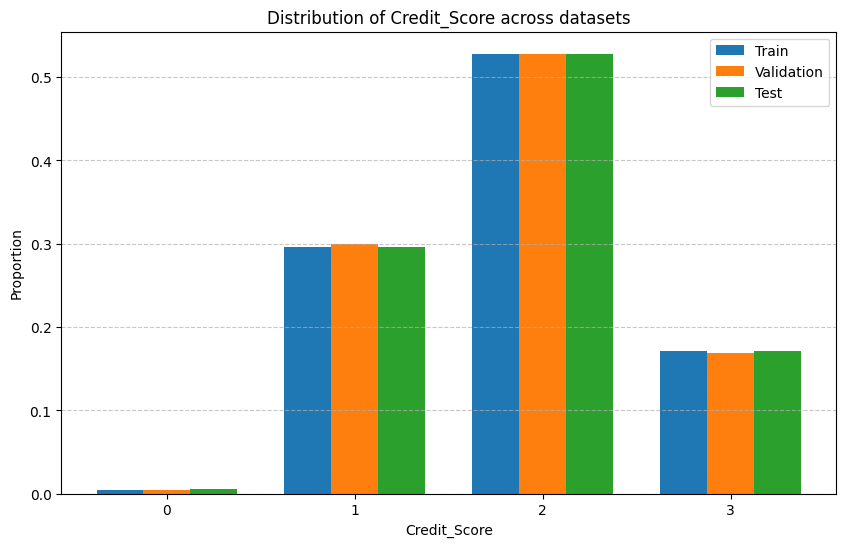

In [19]:
def check_credit_score_distribution(train_df, val_df, test_df, target_column='Credit_Score'):
    # Calculate distribution in each set
    train_dist = train_df[target_column].value_counts(normalize=True).sort_index()
    val_dist = val_df[target_column].value_counts(normalize=True).sort_index()
    test_dist = test_df[target_column].value_counts(normalize=True).sort_index()
    
    # Display distributions
    print("Distribution of", target_column)
    print("\nTrain set distribution:")
    print(train_dist)
    print("\nValidation set distribution:")
    print(val_dist)
    print("\nTest set distribution:")
    print(test_dist)
    
    # Visual check with bar chart
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Ensure all datasets have the same categories for comparison
    all_values = sorted(set(train_dist.index) | set(val_dist.index) | set(test_dist.index))
    
    # Create DataFrames with consistent indices
    train_df_aligned = pd.Series([train_dist.get(val, 0) for val in all_values], index=all_values)
    val_df_aligned = pd.Series([val_dist.get(val, 0) for val in all_values], index=all_values)
    test_df_aligned = pd.Series([test_dist.get(val, 0) for val in all_values], index=all_values)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    width = 0.25
    x = range(len(all_values))
    
    plt.bar([i-width for i in x], train_df_aligned, width=width, label='Train')
    plt.bar(x, val_df_aligned, width=width, label='Validation')
    plt.bar([i+width for i in x], test_df_aligned, width=width, label='Test')
    
    plt.xlabel(target_column)
    plt.ylabel('Proportion')
    plt.title(f'Distribution of {target_column} across datasets')
    plt.xticks(x, all_values)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

# Use the function
check_credit_score_distribution(train_df, val_df, test_df, 'Credit_Score')

Seems like datasplit was a success because more or less the categories have the same distribution across different datasets.

In [20]:
#Separate features and target
X_train = train_df.drop('Credit_Score', axis=1)
y_train = train_df['Credit_Score']
X_val=val_df.drop('Credit_Score', axis=1)
y_val = val_df['Credit_Score']
X_test=test_df.drop('Credit_Score', axis=1)
y_test=test_df['Credit_Score']

Needed in the future analysis.

# Evaluate different resampling techniques
- The bar chart above reminds us of the uneven category distribution in the target variable 'Credit score' which was identified in EDA and will be addressed here
- Classes can be balanced using different resampling techniques: oversampling vs. undersampling. 
- Proposed solutions may be using SMOTE, SMOTE-ENN (combining SMOTE with ENN under-samling to reduce noise), custom smote, sample weights and class weights.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter
import pandas as pd

# Check original distribution
print("Original training distribution:")
print(Counter(y_train))
print("\nOriginal training distribution (%):")
for class_label, count in Counter(y_train).items():
    print(f"Class {class_label}: {count/len(y_train)*100:.2f}%")

# Dictionary to store results
results = {}

# Define all balancing methods to try
balancing_methods = {
    'Baseline': {
        'description': '1. BASELINE MODEL (No balancing)',
        'transform': lambda X, y: (X, y),  # No transformation
        'model_params': {},  # No special parameters
        'fit_params': {}     # No special fit parameters
    },
    'SMOTE': {
        'description': '2. STANDARD SMOTE',
        'transform': lambda X, y: SMOTE(random_state=42).fit_resample(X, y),
        'model_params': {},
        'fit_params': {}
    },
    'SMOTE-ENN': {
        'description': '3. SMOTE-ENN',
        'transform': lambda X, y: SMOTEENN(random_state=42).fit_resample(X, y),
        'model_params': {},
        'fit_params': {}
    },
    'Custom SMOTE': {
        'description': '4. CUSTOM SMOTE (Partial Balancing)',
        'transform': lambda X, y: SMOTE(
            sampling_strategy={
                0: int(len(y) * 0.05),  # Extreme minority to ~5%
                # Skip majority class
                # Increase other classes by 50% (this assumes class 0 is extreme minority)
                **{k: int(v * 1.5) for k, v in Counter(y).items() 
                   if k != 0 and k != max(Counter(y), key=Counter(y).get)}
            },
            random_state=42
        ).fit_resample(X, y),
        'model_params': {},
        'fit_params': {}
    },
    'Sample Weights': {
        'description': '5. SAMPLE WEIGHTS',
        'transform': lambda X, y: (X, y),  # Use original data
        'model_params': {},
        'fit_params': {'sample_weight': compute_sample_weight('balanced', y_train)}
    },
    'Class Weights': {
        'description': '6. CLASS WEIGHTS',
        'transform': lambda X, y: (X, y),  # Use original data
        'model_params': {'class_weight': 'balanced'},
        'fit_params': {}
    }
}

# Process each balancing method
for method_name, config in balancing_methods.items():
    print("\n"+config['description'])
    
    # Apply transformation (resampling or none)
    X_train_balanced, y_train_balanced = config['transform'](X_train, y_train)
    
    # Print distribution for resampling methods
    if method_name not in ['Baseline', 'Sample Weights', 'Class Weights']:
        print(f"Resampled class distribution: {Counter(y_train_balanced)}")
    
    # Create and train model
    model = RandomForestClassifier(n_estimators=100, random_state=42, **config['model_params'])
    model.fit(X_train_balanced, y_train_balanced, **config['fit_params'])
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    results[method_name] = {
        'accuracy': accuracy_score(y_val, y_pred),
        'f1_macro': f1_score(y_val, y_pred, average='macro'),
        'f1_weighted': f1_score(y_val, y_pred, average='weighted'),
        'mae': mean_absolute_error(y_val, y_pred)
    }

# Create comparison table
print("\nCOMPARISON OF ALL METHODS")

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df)

# Find best method for each metric
print("\nBest method for each metric:")
for metric in results_df.columns:
    if metric == 'mae':
        best_method = results_df[metric].idxmin()
        best_value = results_df[metric].min()
    else:
        best_method = results_df[metric].idxmax()
        best_value = results_df[metric].max()
    print(f"{metric}: {best_method} ({best_value:.4f})")

Original training distribution:
Counter({2: 2885, 1: 1619, 3: 934, 0: 23})

Original training distribution (%):
Class 1: 29.65%
Class 2: 52.83%
Class 3: 17.10%
Class 0: 0.42%

1. BASELINE MODEL (No balancing)

2. STANDARD SMOTE
Resampled class distribution: Counter({1: 2885, 2: 2885, 3: 2885, 0: 2885})

3. SMOTE-ENN
Resampled class distribution: Counter({0: 2266, 3: 1493, 1: 1214, 2: 381})

4. CUSTOM SMOTE (Partial Balancing)
Resampled class distribution: Counter({2: 2885, 1: 2428, 3: 1401, 0: 273})

5. SAMPLE WEIGHTS

6. CLASS WEIGHTS

COMPARISON OF ALL METHODS
                accuracy  f1_macro  f1_weighted     mae
Baseline          0.9800    0.9839       0.9799  0.0200
SMOTE             0.9800    0.9838       0.9799  0.0206
SMOTE-ENN         0.9666    0.9725       0.9667  0.0384
Custom SMOTE      0.9789    0.9832       0.9788  0.0211
Sample Weights    0.9800    0.9839       0.9799  0.0200
Class Weights     0.9800    0.9839       0.9799  0.0200

Best method for each metric:
accuracy:

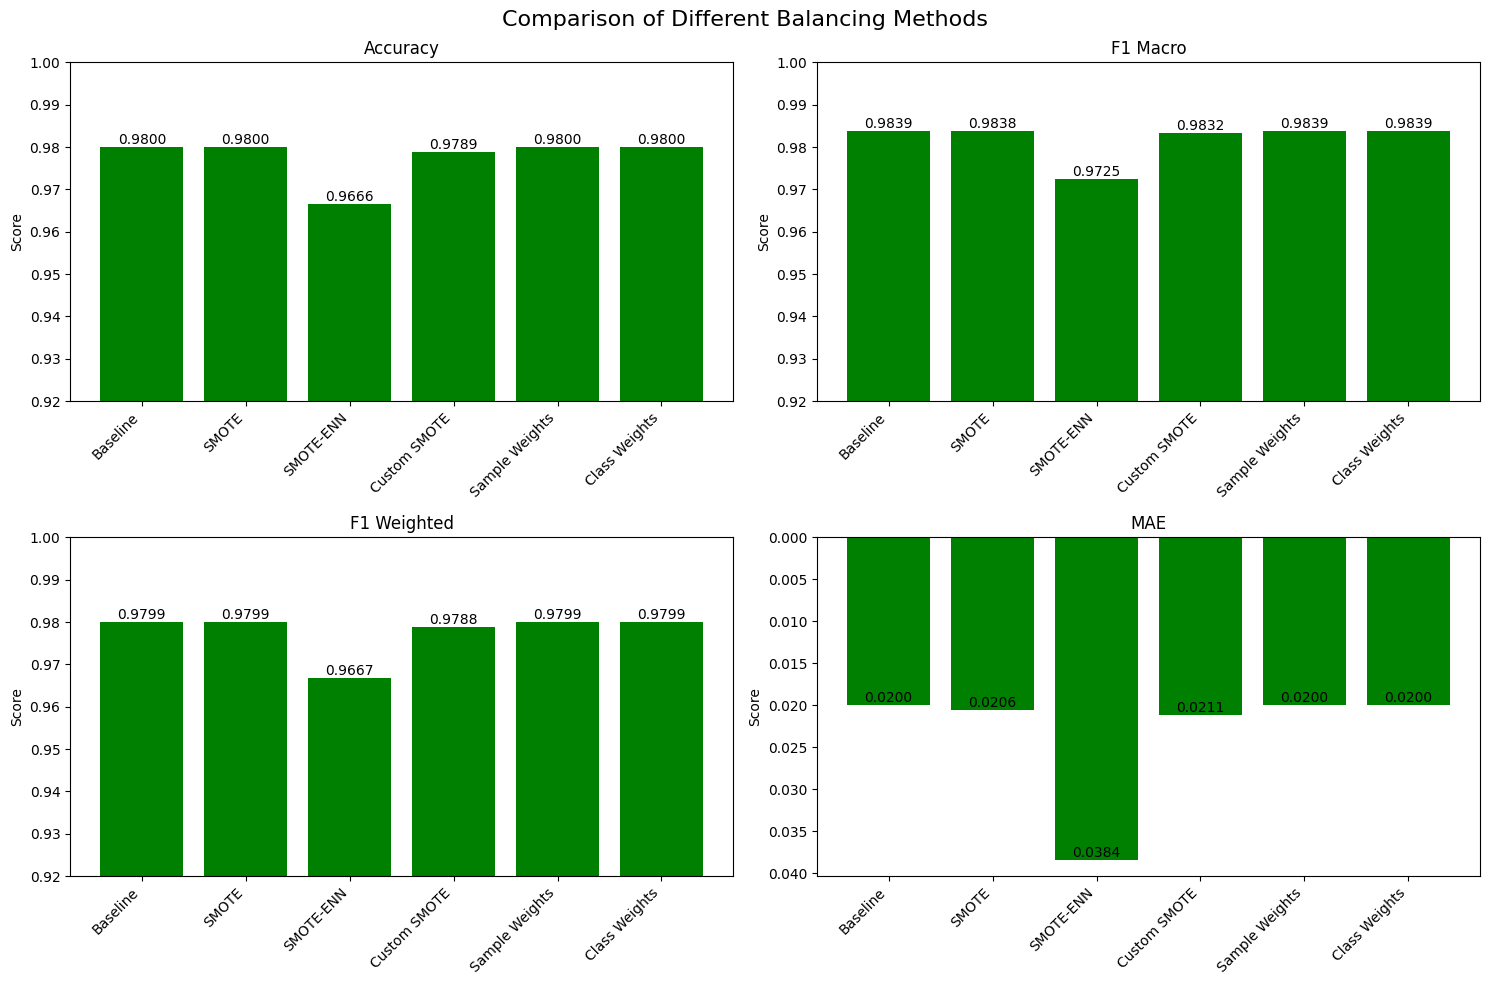

In [22]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparison of Different Balancing Methods', fontsize=16)

metrics = ['accuracy', 'f1_macro', 'f1_weighted', 'mae']
titles = ['Accuracy', 'F1 Macro', 'F1 Weighted', 'MAE']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    values = results_df[metric]
    bars = ax.bar(values.index, values, color='green')
    ax.set_title(title)
    ax.set_ylabel('Score')

    ax.set_xticks(range(len(values.index)))
    ax.set_xticklabels(values.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}',
                ha='center', va='bottom')
    
    # Invert y-axis for MAE (lower is better)
    if metric == 'mae':
        ax.invert_yaxis()
    else:
        ax.set_ylim(0.92, 1.0)

plt.tight_layout()
plt.show()

## Custom SMOTE
- We can use grid search cross validation to find the best parameters for custom SMOTE

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'smote__k_neighbors': 3, 'smote__minority_ratio': 0.07, 'smote__other_minority_multiplier': 1.8}
Best MAE (CV): 0.02087643981514064

Validation Performance:
MAE: 0.0206
F1 Macro: 0.9836
Accuracy: 0.9794

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.98      0.98      0.98       538
           2       0.97      0.99      0.98       948
           3       0.99      0.95      0.97       304

    accuracy                           0.98      1797
   macro avg       0.99      0.98      0.98      1797
weighted avg       0.98      0.98      0.98      1797



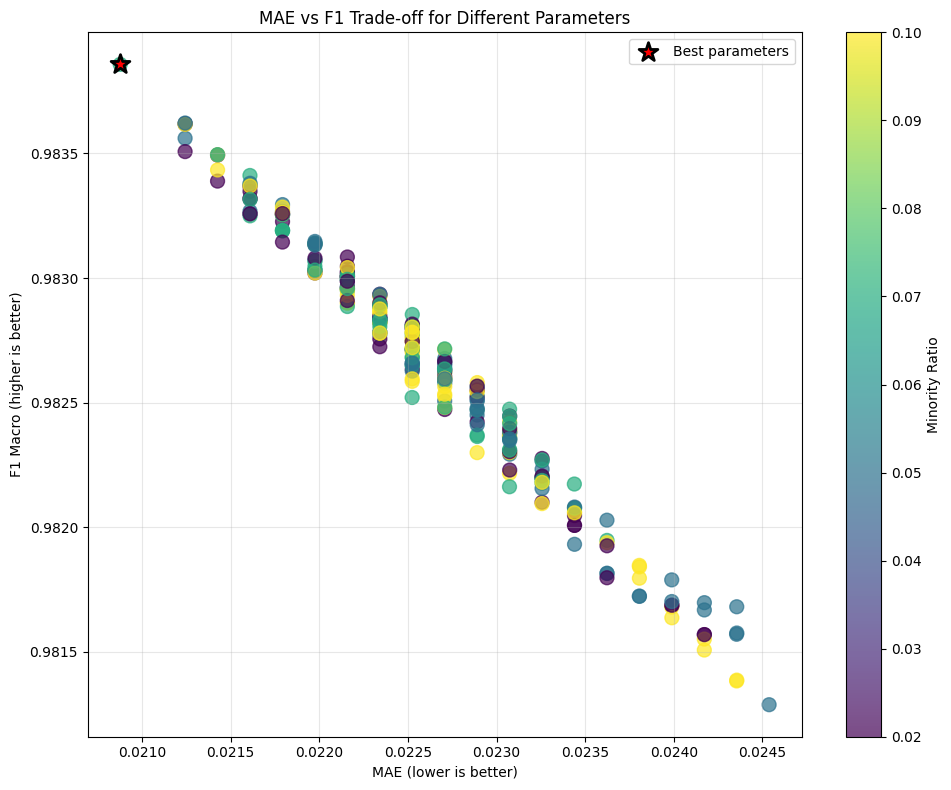


Best SMOTE parameters:
smote__k_neighbors: 3
smote__minority_ratio: 0.07
smote__other_minority_multiplier: 1.8


In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from joblib import Parallel, delayed

# Define custom scorer for ordinal classification
def ordinal_mae_score(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)  # Negative because GridSearchCV maximizes

# Replace your existing CustomSMOTE class with this one
class CustomSMOTE(SMOTE):
    def __init__(self, minority_ratio=0.05, other_minority_multiplier=1.5, 
                 sampling_strategy='auto', random_state=None, k_neighbors=5,
                 n_jobs=1):  # Added n_jobs parameter
        # Initialize parent class with SMOTE parameters
        super().__init__(
            sampling_strategy=sampling_strategy,
            random_state=random_state,
            k_neighbors=k_neighbors
        )
        self.minority_ratio = minority_ratio
        self.other_minority_multiplier = other_minority_multiplier
        self.n_jobs = n_jobs  # Store n_jobs parameter
    
    def fit_resample(self, X, y):
        # Create custom sampling strategy
        counts = Counter(y)
        total = len(y)
        majority_class = max(counts, key=counts.get)
        
        strategy = {}
        for class_label, count in counts.items():
            if class_label == 0:  # Extreme minority class
                strategy[class_label] = int(total * self.minority_ratio)
            elif class_label == majority_class:
                continue
            else:
                strategy[class_label] = int(count * self.other_minority_multiplier)
        
        # Update the sampling strategy
        self.sampling_strategy = strategy
        return super().fit_resample(X, y)

# Now you can use n_jobs in your pipeline
pipeline = ImbPipeline([
    ('smote', CustomSMOTE(random_state=42, n_jobs=-1)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define parameter grid
param_grid = {
    'smote__minority_ratio': [0.02, 0.05, 0.07, 0.10],
    'smote__other_minority_multiplier': [1.2, 1.5, 1.8, 2.0],
    'smote__k_neighbors': [3, 5, 7],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20]
}

# Create custom scoring
scoring = {
    'mae': make_scorer(ordinal_mae_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    refit='mae',  # Optimize for MAE
    n_jobs=-1,  # Parallel computing
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest parameters:", grid_search.best_params_)
print("Best MAE (CV):", -grid_search.best_score_)

# Evaluate on validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print("\nValidation Performance:")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.4f}")
print(f"F1 Macro: {f1_score(y_val, y_pred, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

# Show detailed classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Visualize the results
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(grid_search.cv_results_)


# Extract the best SMOTE parameters
best_smote_params = {k: v for k, v in grid_search.best_params_.items() if k.startswith('smote__')}
print("\nBest SMOTE parameters:")
for param, value in best_smote_params.items():
    print(f"{param}: {value}")

### Apply the custom SMOTE with the fine-tuned parameters

In [24]:
# Apply best parameters and show distribution
best_smote = CustomSMOTE(
    minority_ratio=grid_search.best_params_['smote__minority_ratio'],
    other_minority_multiplier=grid_search.best_params_['smote__other_minority_multiplier'],
    k_neighbors=grid_search.best_params_['smote__k_neighbors'],
    random_state=42
)

regular_smote = SMOTE(random_state=42)
X_train_best, y_train_best = regular_smote.fit_resample(X_train, y_train)

print("\nOriginal distribution:")
print(Counter(y_train))
print("\nResampled distribution with best parameters:")
print(Counter(y_train_best))


Original distribution:
Counter({2: 2885, 1: 1619, 3: 934, 0: 23})

Resampled distribution with best parameters:
Counter({1: 2885, 2: 2885, 3: 2885, 0: 2885})


# Feature Scaling: Fit and Transform (or other method)

--> the scaling is necessary only for certain type of models like Logistic Regression. If you implement tree models, like Decision Tree, Random Forest, XGBoost... you can skip this part
- Evaluating different scaler methods out of Standard scaler, MinMax scaler and Robust scaler, and choosing the best to use
- Using Logistic regression to evaluate because it is sensitive to scaling
- Scaling is needed in the future for SVM model training

In [25]:
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

# Test different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

results = []
for name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train_best)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
   
    # Train and evaluate
    model = LogisticRegression(max_iter=5000)
    model.fit(X_train_scaled, y_train_best)
   
    # Make predictions on validation set
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)
   
    # Calculate metrics using validation set
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    logloss = log_loss(y_val, y_pred_proba)
   
    # Calculate mean absolute error (good for ordinal)
    mae = np.mean(np.abs(y_pred - y_val))
   
    results.append({
        'Scaler': name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'MAE': mae
    })

# Show results
results_df = pd.DataFrame(results)
pd.options.display.float_format = '{:.5f}'.format
print(results_df)

# Find best scaler based on metrics
print("\nBest performers:")
print(f"Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Scaler']} ({results_df['Accuracy'].max():.5f})")
print(f"F1 Score: {results_df.loc[results_df['F1 Score'].idxmax(), 'Scaler']} ({results_df['F1 Score'].max():.5f})")
print(f"Log Loss: {results_df.loc[results_df['Log Loss'].idxmin(), 'Scaler']} ({results_df['Log Loss'].min():.5f})")
print(f"MAE: {results_df.loc[results_df['MAE'].idxmin(), 'Scaler']} ({results_df['MAE'].min():.5f})")

           Scaler  Accuracy  F1 Score  Log Loss     MAE
0  StandardScaler   0.97218   0.97211   0.07558 0.03228
1    MinMaxScaler   0.97273   0.97266   0.07558 0.03172
2    RobustScaler   0.97162   0.97156   0.07493 0.03228

Best performers:
Accuracy: MinMaxScaler (0.97273)
F1 Score: MinMaxScaler (0.97266)
Log Loss: RobustScaler (0.07493)
MAE: MinMaxScaler (0.03172)


- We can see that `MinMaxScaler` is the best scaler at MAE, accuracy and f1 scores while `StandardScaler` is the best at log loss. 
- MAE is very important for ordinal classification -> `so we will use MinMaxScaler`.

In [26]:
# Create a scaler instance
scaler = MinMaxScaler()

# Fit the scaler on the training data and apply the transformation on validation and test sets
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_best),
    columns=X_val.columns
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

# Check that each feature in the training set now has mean ~0 and variance ~1
print("Means of scaled features (≈0):", np.round(X_train_scaled.mean(axis=0), 3))
print("Variances of scaled features (≈1):", np.round(X_train_scaled.var(axis=0), 3))

Means of scaled features (≈0): Month                         0.52900
Street                        0.41900
Age                           0.50500
Occupation                    0.55500
Annual_Income                 0.02600
Monthly_Inhand_Salary         0.33300
Num_Bank_Accounts             0.37200
Num_Credit_Card               0.41600
Interest_Rate                 0.28900
Num_of_Loan                   0.29700
Delay_from_due_date           0.29000
Num_of_Delayed_Payment        0.02900
Changed_Credit_Limit          0.43000
Num_Credit_Inquiries          0.29700
Credit_Mix                    0.47100
Outstanding_Debt              0.26800
Credit_Utilization_Ratio      0.41200
Credit_History_Age            0.61100
Amount_invested_monthly       0.07200
Has_Payday_Loan               0.17200
Has_Credit_Builder_Loan       0.18400
Has_Not_Specified_Loan        0.16900
Has_Home_Equity_Loan          0.16400
Has_Mortgage_Loan             0.17900
Has_Personal_Loan             0.15700
Has_Student_Loan   

Implemented minmax scaler.

# Drop City columns
- It introduces bias

In [27]:
# Drop the City column
X_train_scaled = X_train_scaled.drop(['City_BadShire', 'City_Lonton', 'City_Standhampton', 'City_Unknown', 'City_ZeroVille'], axis=1)
X_val_scaled = X_val_scaled.drop(['City_BadShire', 'City_Lonton', 'City_Standhampton', 'City_Unknown', 'City_ZeroVille'], axis=1)
X_test_scaled = X_test_scaled.drop(['City_BadShire', 'City_Lonton', 'City_Standhampton', 'City_Unknown', 'City_ZeroVille'], axis=1)

# Testing models
- Chose Random Forest, Gradient Boosting, SVC and XGBoost as candidate models
- Used parallel computing to reduce time of computations

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from joblib import Parallel, delayed

# Initialize the models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVC (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', n_jobs=-1)
}

# Function to train and evaluate a single model
def train_and_evaluate(name, model, X_train, y_train, X_val, y_val):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Compute metrics
    train_acc = accuracy_score(y_train, train_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_mae = mean_absolute_error(y_val, val_pred)
    
    return {
        'name': name,
        'train_acc': train_acc,
        'train_mae': train_mae,
        'val_acc': val_acc,
        'val_mae': val_mae
    }

# Run training in parallel
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(name, model, X_train_scaled, y_train_best, X_val_scaled, y_val)
    for name, model in models.items()
)

# Print results
for result in results:
    print(f"{result['name']}:")
    print(f"  Training Accuracy:   {result['train_acc']:.4f}")
    print(f"  Training MAE:        {result['train_mae']:.4f}")
    print(f"  Validation Accuracy: {result['val_acc']:.4f}")
    print(f"  Validation MAE:      {result['val_mae']:.4f}\n")

RandomForest:
  Training Accuracy:   1.0000
  Training MAE:        0.0000
  Validation Accuracy: 0.8086
  Validation MAE:      0.2059

GradientBoosting:
  Training Accuracy:   0.8964
  Training MAE:        0.1184
  Validation Accuracy: 0.7997
  Validation MAE:      0.2065

SVC (RBF):
  Training Accuracy:   0.8670
  Training MAE:        0.1744
  Validation Accuracy: 0.7691
  Validation MAE:      0.2743

XGBoost:
  Training Accuracy:   0.9997
  Training MAE:        0.0003
  Validation Accuracy: 0.8041
  Validation MAE:      0.2031



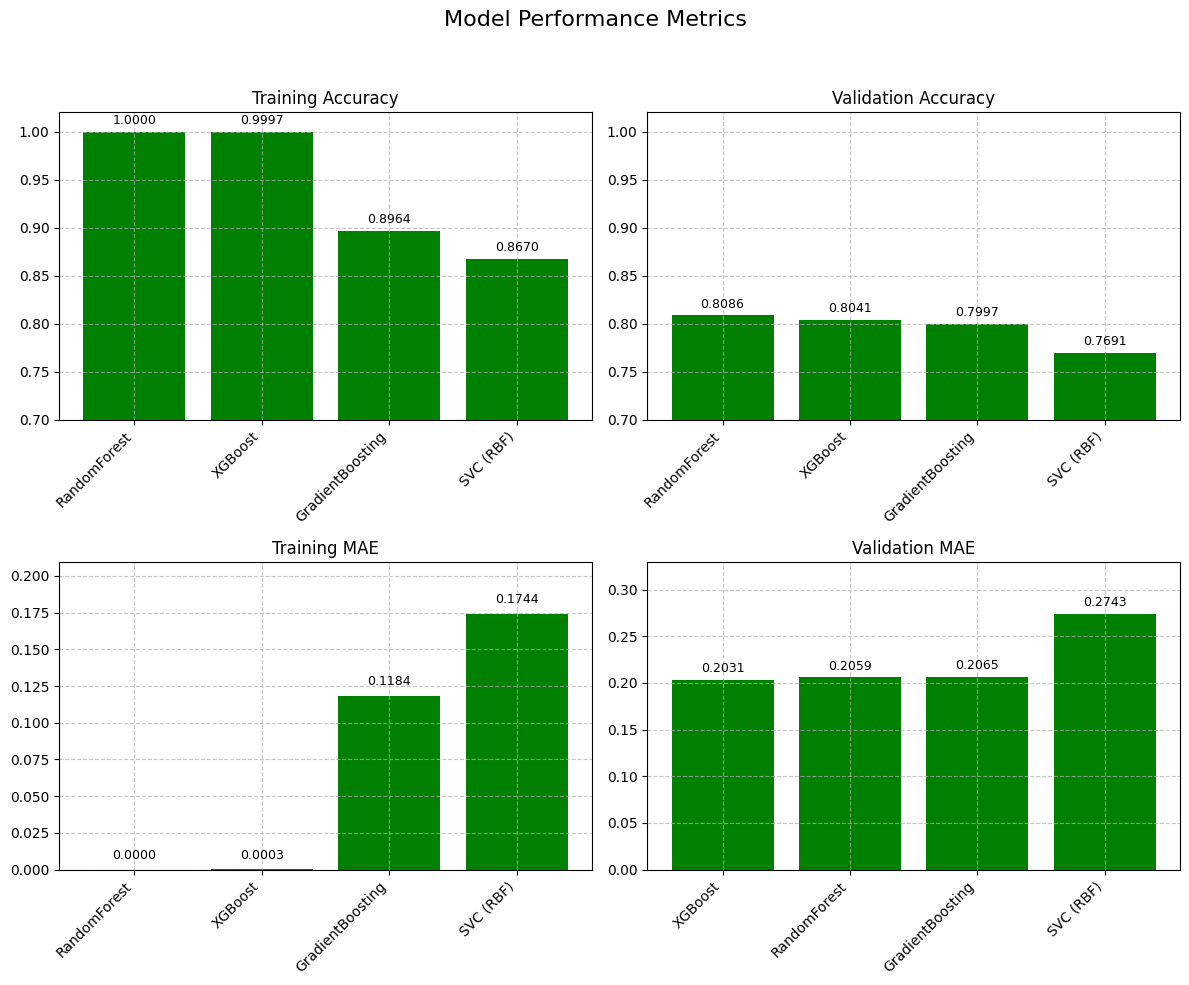

In [29]:
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Create a figure with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Performance Metrics', fontsize=16)

# Define metrics to plot
metrics = [
    {'name': 'Training Accuracy', 'col': 'train_acc', 'pos': (0, 0)},
    {'name': 'Validation Accuracy', 'col': 'val_acc', 'pos': (0, 1)},
    {'name': 'Training MAE', 'col': 'train_mae', 'pos': (1, 0)},
    {'name': 'Validation MAE', 'col': 'val_mae', 'pos': (1, 1)}
]

# Create a bar plot for each metric
for metric in metrics:
    row, col = metric['pos']
    ax = axs[row, col]
    
    # Sort data by the metric value (descending for accuracy, ascending for MAE)
    sort_ascending = 'mae' in metric['col']
    sorted_data = df_results.sort_values(by=metric['col'], ascending=sort_ascending)
    
    # Create bar chart
    bars = ax.bar(
        np.arange(len(sorted_data)),
        sorted_data[metric['col']],
        color='green'
    )
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.005,
            f'{height:.4f}',
            ha='center', va='bottom',
            fontsize=9
        )
    
    # Set title and labels
    ax.set_title(metric['name'])
    ax.set_xticks(np.arange(len(sorted_data)))
    ax.set_xticklabels(sorted_data['name'], rotation=45, ha='right')
    
    # Set appropriate y-axis limits
    if 'acc' in metric['col']:
        ax.set_ylim(0.7, 1.02) 
    else:
        # For MAE metrics (lower is better)
        ax.set_ylim(0, max(df_results[metric['col']]) * 1.2)

    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the suptitle
plt.show()

**Insight:**  
RandomForest shows perfect fit on training data but a noticeable drop on validation, suggesting some overfitting. Gradient Boosting is more balanced between training and validation, while SVC exhibits the lowest performance overall. XGBoost almost perfect training accuracy and mae, but a big drop on validation accuracy an mae as RandomForest. 

**Next Step:**  
Tune the best performing RandomForest and XGBoost models hyperparameters (e.g., `n_estimators`, `max_depth`, `max_features`) using a fast `RandomizedSearchCV` to reduce overfitting and improve validation accuracy.  

# Hyperparameter tuning for the models

In [30]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, mean_absolute_error, accuracy_score
from joblib import Parallel, delayed
import multiprocessing

# Create scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Base models to tune
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Broad param distributions for RandomizedSearchCV
rand_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
}

# 2-fold stratified CV
cv_fast = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Function to tune a single model
def tune_model(name, base, param_space, X_train, y_train):
    # Randomized search with multiple metrics
    rnd = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_space,
        n_iter=4,
        scoring=scorers,
        refit='mae',  # mae rlly important for ordinal classification
        cv=cv_fast,
        random_state=42,
        n_jobs=-1,  #Parallelize
        verbose=0,
        return_train_score=True
    )
    
    print(f"Starting RandomizedSearchCV for {name}...")
    rnd.fit(X_train, y_train)
    best_params = rnd.best_params_
    
    # Build a tiny grid around the best params
    grid_space = {k: [v] for k, v in best_params.items()}
    
    # Grid search to confirm
    grd = GridSearchCV(
        estimator=base,
        param_grid=grid_space,
        scoring=scorers,
        refit='mae',  # mae really important for ordinal classification
        cv=cv_fast,
        n_jobs=-1,  #Parallelize
        verbose=0,
        return_train_score=True
    )
    
    print(f"Starting GridSearchCV for {name}...")
    grd.fit(X_train, y_train)
    
    # Get the best scores for each metric
    best_idx = grd.best_index_
    results = {
        'name': name,
        'estimator': grd.best_estimator_,
        'params': grd.best_params_,
        'accuracy': grd.cv_results_['mean_test_accuracy'][best_idx],
        'f1': grd.cv_results_['mean_test_f1_weighted'][best_idx],
        'mae': -grd.cv_results_['mean_test_mae'][best_idx]  # Negative because of greater_is_better=False
    }
    
    return results

# Calculate optimal core allocation
n_cores = multiprocessing.cpu_count() #how many cores are there
n_models = len(models)

n_jobs_outer = 1 #how many models are running in parallel
n_jobs_inner = n_cores - 1 #how many jobs are running in parallel inside each model

print(f"Using {n_jobs_outer} parallel model trainings with {n_jobs_inner} cores each")

# Run model tuning in parallel
results = Parallel(n_jobs=n_jobs_outer)(
    delayed(tune_model)(name, base, rand_spaces[name], X_train_scaled, y_train_best)
    for name, base in models.items()
)

# Store results and print summary
best_estimators = {}
print("\n" + "="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)

for result in results:
    name = result['name']
    best_estimators[name] = result['estimator']
    
    print(f"\n{name}:")
    print(f"  Best Parameters: {result['params']}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  F1 Score: {result['f1']:.4f}")
    print(f"  MAE: {result['mae']:.4f}")

# Create comparison dataframe
comparison_data = []
for result in results:
    comparison_data.append({
        'Model': result['name'],
        'Accuracy': result['accuracy'],
        'F1 Score': result['f1'],
        'MAE': result['mae']
    })

df_comparison = pd.DataFrame(comparison_data)

# Print best overall model
best_model_by_mae = min(results, key=lambda x: x['mae'])
print(f"\nBest Model (by F1 Score): {best_model_by_mae['name']}")
print(f"F1 Score: {best_model_by_mae['f1']:.4f}")

Using 1 parallel model trainings with 11 cores each
Starting RandomizedSearchCV for RandomForest...
Starting GridSearchCV for RandomForest...
Starting RandomizedSearchCV for XGBoost...
Starting GridSearchCV for XGBoost...

HYPERPARAMETER TUNING RESULTS

RandomForest:
  Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
  Accuracy: 0.8828
  F1 Score: 0.8827
  MAE: 0.1334

XGBoost:
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
  Accuracy: 0.8912
  F1 Score: 0.8912
  MAE: 0.1220

Best Model (by F1 Score): XGBoost
F1 Score: 0.8912


In [31]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, mean_absolute_error, accuracy_score

# Create scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Base models to tune
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Broad param distributions for RandomizedSearchCV
rand_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
}

# 2-fold stratified CV
cv_fast = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Function to tune a model and evaluate on validation set
def tune_model(name, base, param_space, X_train, y_train, X_val, y_val):
    # Randomized search with multiple metrics
    rnd = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_space,
        n_iter=4,
        scoring=scorers,
        refit='mae',  # mae really important for ordinal classification
        cv=cv_fast,
        random_state=42,
        n_jobs=-1,  # Parallelize
        verbose=0,
        return_train_score=True
    )
    
    print(f"Starting RandomizedSearchCV for {name}...")
    rnd.fit(X_train, y_train)
    best_params = rnd.best_params_
    
    # Build a tiny grid around the best params
    grid_space = {k: [v] for k, v in best_params.items()}
    
    # Grid search to confirm
    grd = GridSearchCV(
        estimator=base,
        param_grid=grid_space,
        scoring=scorers,
        refit='mae',  # mae really important for ordinal classification
        cv=cv_fast,
        n_jobs=-1,  # Parallelize
        verbose=0,
        return_train_score=True
    )
    
    print(f"Starting GridSearchCV for {name}...")
    grd.fit(X_train, y_train)
    
    # Get the best model
    best_model = grd.best_estimator_
    
    # Make predictions on training and validation sets
    train_pred = best_model.predict(X_train)
    val_pred = best_model.predict(X_val)
    
    # Compute metrics
    cv_best_idx = grd.best_index_
    results = {
        'name': name,
        'estimator': best_model,
        'params': grd.best_params_,
        # Training set metrics
        'train_accuracy': accuracy_score(y_train, train_pred),
        'train_f1': f1_score(y_train, train_pred, average='weighted'),
        'train_mae': mean_absolute_error(y_train, train_pred),
        # Validation set metrics
        'val_accuracy': accuracy_score(y_val, val_pred),
        'val_f1': f1_score(y_val, val_pred, average='weighted'),
        'val_mae': mean_absolute_error(y_val, val_pred)
    }
    
    return results

# Calculate optimal core allocation
n_cores = multiprocessing.cpu_count() # how many cores are there
n_models = len(models)

n_jobs_outer = 1 # how many models are running in parallel
n_jobs_inner = n_cores - 1 # how many jobs are running in parallel inside each model

print(f"Using {n_jobs_outer} parallel model trainings with {n_jobs_inner} cores each")

# Run model tuning in parallel
results = Parallel(n_jobs=n_jobs_outer)(
    delayed(tune_model)(name, base, rand_spaces[name], X_train_scaled, y_train_best, X_val_scaled, y_val)
    for name, base in models.items()
)

# Store results and print summary
best_estimators = {}
for result in results:
    name = result['name']
    best_estimators[name] = result['estimator']
    
    print(f"\n{name}:")
    print(f"  Best Parameters: {result['params']}")
    print("  Training Set Metrics:")
    print(f"    Accuracy: {result['train_accuracy']:.4f}")
    print(f"    F1 Score: {result['train_f1']:.4f}")
    print(f"    MAE: {result['train_mae']:.4f}")
    print("  Validation Set Metrics:")
    print(f"    Accuracy: {result['val_accuracy']:.4f}")
    print(f"    F1 Score: {result['val_f1']:.4f}")
    print(f"    MAE: {result['val_mae']:.4f}")

# Create comparison dataframe
comparison_data = []
for result in results:
    comparison_data.append({
        'Model': result['name'],
        'Val_Accuracy': result['val_accuracy'],
        'Val_F1': result['val_f1'],
        'Val_MAE': result['val_mae']
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nComparison DataFrame:")
print(df_comparison.round(4))

Using 1 parallel model trainings with 11 cores each
Starting RandomizedSearchCV for RandomForest...
Starting GridSearchCV for RandomForest...
Starting RandomizedSearchCV for XGBoost...
Starting GridSearchCV for XGBoost...

RandomForest:
  Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
  Training Set Metrics:
    Accuracy: 1.0000
    F1 Score: 1.0000
    MAE: 0.0000
  Validation Set Metrics:
    Accuracy: 0.8058
    F1 Score: 0.8056
    MAE: 0.2076

XGBoost:
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
  Training Set Metrics:
    Accuracy: 0.9950
    F1 Score: 0.9950
    MAE: 0.0052
  Validation Set Metrics:
    Accuracy: 0.8069
    F1 Score: 0.8062
    MAE: 0.1998

Comparison DataFrame:
          Model  Val_Accuracy  Val_F1  Val_MAE
0  RandomForest       0.80580 0.80560  0.20760
1       XGBoost       0.80690 0.80620  0.19980


**Summary:**  
- XGBoost is best at accuracy, F1 score and MAE than RandomForest by a small margin.
- The models perform worse on validation sets, meaning some overfitting has taken place.

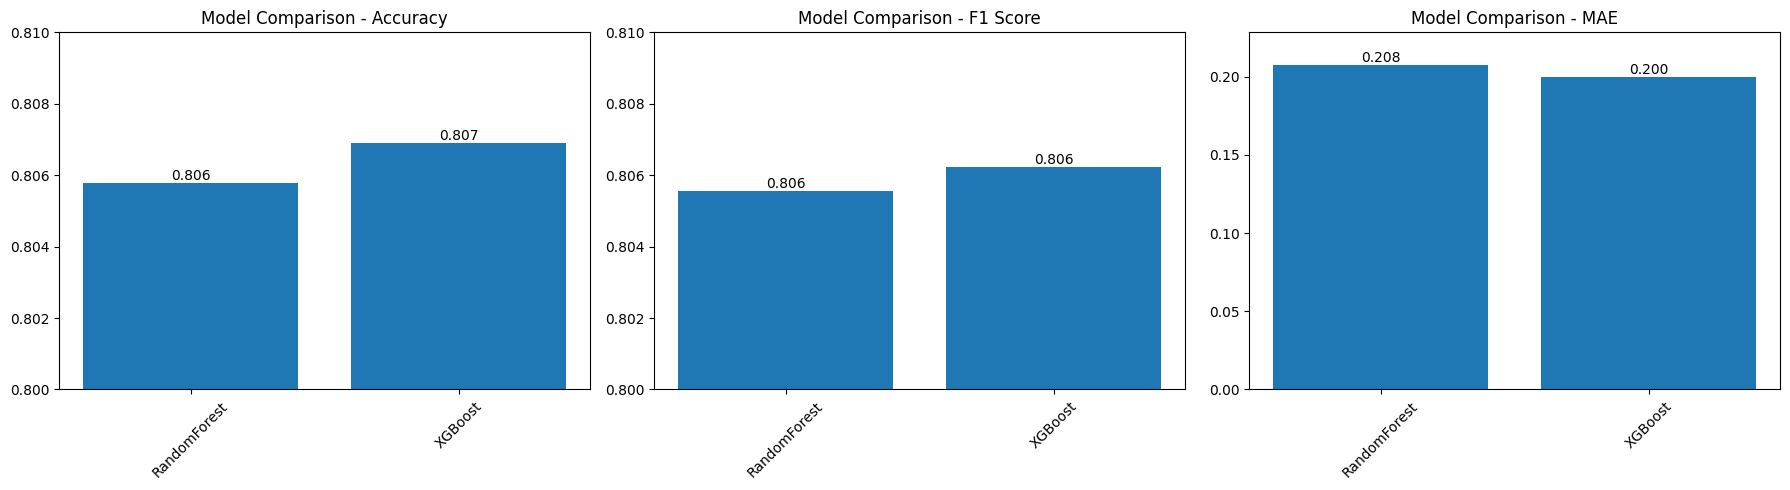

In [32]:
#Visualise results
# Plot comparison with score labels
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define a function to add labels to bars
def add_labels_to_bars(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=10,
        )

# Accuracy
bars = axes[0].bar(df_comparison['Model'], df_comparison['Val_Accuracy'])
axes[0].set_title('Model Comparison - Accuracy')
axes[0].set_ylim(0.8, 0.81)  # Increased upper limit to make room for labels
axes[0].tick_params(axis='x', rotation=45)
add_labels_to_bars(axes[0], bars)

# F1 Score
bars = axes[1].bar(df_comparison['Model'], df_comparison['Val_F1'])
axes[1].set_title('Model Comparison - F1 Score')
axes[1].set_ylim(0.8, 0.81)  # Increased upper limit to make room for labels
axes[1].tick_params(axis='x', rotation=45)
add_labels_to_bars(axes[1], bars)

# MAE
bars = axes[2].bar(df_comparison['Model'], df_comparison['Val_MAE'])
axes[2].set_title('Model Comparison - MAE')
# Automatically determine a good y-limit based on the max value
y_max = max(df_comparison['Val_MAE']) * 1.1
axes[2].set_ylim(0, y_max)
axes[2].tick_params(axis='x', rotation=45)
add_labels_to_bars(axes[2], bars)

plt.tight_layout()
plt.show()